Note for the start: *I was a bit shocked that here on kaggle only a few notebooks exist, daring to predict the M5 with uncertainty. Most of the notebooks simply translate the results of the accuracy competition.*

I just recently started writing in Python and tried applying a Neural Network to the problem. I am just a beginner in this field, therefore please be patient :)

# M5 Competition - Uncertainty - LSTM Neural Network

1. [Introduction and sources](#sources)


2. [Preparing to start](#prepare)
    * [Loading packages](#packages)
    * [Loading data](#data)
    * [Looking at the hierachy](#hierarchy_ts)
    
    
3. [The submission format](#submission)
    * [Intro](#intro)
    * [Prediction intervals and quartiles](#PIs)
    * [Outlier](#outlier)
    * [Aggregation levels](#sub_aggregation_levels)
    
    
4. [Model Preparation](#Feature_Creation)
    * [Limited Features](#limfeat)
    * [More Features](#morefeat)
    * [Pricing Feature](#pricefeat)
    * [Feature Scaling](#featscale)
    * [Train and Test Data Creation](#traintest)
    
    
5. [LSTM Modeling](#Modeling)
    * [Loss Function](#lossfct)
    * [Running the Model](#runmodel)
    * [Creating the submission file](#submission)

The M5 competition ran from 2 March to 30 June 2020. Basis of the competition is to predict sales forecasts for walm,art stores. For that, we use hierarchical sales data, generously made available by Walmart, starting at the item level and aggregating to that of departments, product categories, stores in three geographical areas of the US: California, Texas, and Wisconsin.

Each row contains an id that is a concatenation of an item_id and a store_id, which is either validation (corresponding to the Public leaderboard), or evaluation (corresponding to the Private leaderboard). 

We are predicting 28 forecast days (F1-F28) of items sold for each row. For the **validation rows**, this corresponds to d_1914 - d_1941, and for the **evaluation rows**, this corresponds to d_1942 - d_1969. (Note: a month before the competition close, the ground truth for the validation rows will be provided.)

Detailed Information can be found [at the university website or](https://mofc.unic.ac.cy/m5-competition/) and [the competition website on kaggle](https://www.kaggle.com/c/m5-forecasting-accuracy/data).

An overview of the data given, can be seen here:

Data exists in three files:
1. File 1: “calendar.csv”: Contains information about the dates the products are sold.
    * date: The date in a “y-m-d” format.
    * wm_yr_wk: The id of the week the date belongs to.
    * weekday: The type of the day (Saturday, Sunday, …, Friday).
    * wday: The id of the weekday, starting from Saturday.
    * month: The month of the date.
    * year: The year of the date.
    * event_name_1: If the date includes an event, the name of this event.
    * event_type_1: If the date includes an event, the type of this event.
    * event_name_2: If the date includes a second event, the name of this event.
    * event_type_2: If the date includes a second event, the type of this event.
    * snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP  purchases on the examined date. 1 indicates that SNAP purchases are allowed.


2. File 2: “sell_prices.csv”: Contains information about the price of the products sold per store and date.
    * store_id: The id of the store where the product is sold. 
    * item_id: The id of the product.
    * wm_yr_wk: The id of the week.
    * sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).  


3. File 3: “sales_train.csv”: Contains the historical daily unit sales data per product and store.
    * item_id: The id of the product.
    * dept_id: The id of the department the product belongs to.
    * cat_id: The id of the category the product belongs to.
    * store_id: The id of the store where the product is sold.
    * state_id: The State where the store is located.
    * d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29. 


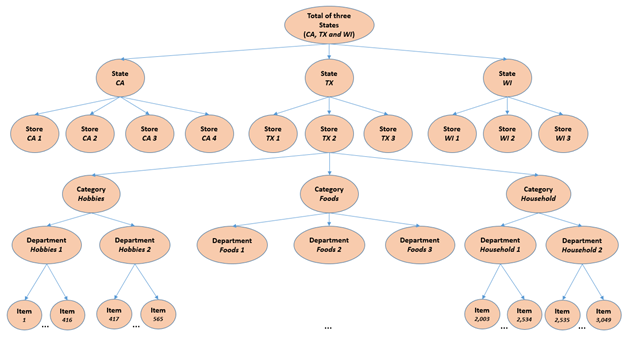

# Sources and guidelines <a class="anchor" id="sources"></a>

Aknowledgements
As a starting point I mainly used these notebooks:  
* [baseline LSTM of Accuracy Prediction](https://www.kaggle.com/bountyhunters/baseline-lstm-with-keras-0-8#Future-Improvements)    
* [Quantile regression, from linear models to trees to deep learning](https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3)
* [Deep Quantiel Regression](https://towardsdatascience.com/deep-quantile-regression-c85481548b5a)
* [M5 Uncertainty Notebook by Allunia](https://www.kaggle.com/allunia/m5-uncertainty)

My other M5 notebook for Accuracy can be seen here: (will be uploaded soon)

# Preparing to start <a class="anchor" id="prepare"></a>

## Loading packages <a class="anchor" id="packages"></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from sklearn.metrics import roc_auc_score
import gc #importing garbage collector
import time
from scipy import signal



import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

SEED = 42
#Pandas - Displaying more rorws and columns
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
timesteps = 14
startDay = 0

## Loading data <a class="anchor" id="data"></a>

In [4]:
df_train = pd.read_csv('/kaggle/input/m5-forecasting-uncertainty/sales_train_validation.csv')
df_prices = pd.read_csv('/kaggle/input/m5-forecasting-uncertainty/sell_prices.csv')
df_days = pd.read_csv('/kaggle/input/m5-forecasting-uncertainty/calendar.csv')

df_train = reduce_mem_usage(df_train)
df_prices = reduce_mem_usage(df_prices)
df_days = reduce_mem_usage(df_days)

Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to  0.12 Mb (41.9% reduction)


## Looking at the hierachy <a class="anchor" id="hierarchy_ts"></a>

In the competition guideline we can find that the hierarchy consits of 12 levels. Let's try to reconstruct some of them:

1. The top is given by the unit sales of all products, aggregated for all stores/states. 
2. Unit sales of all products, aggregated for each state.
3. Unit sales of all products, aggregated for each store.
4. Unit sales of all products, aggregated for each category.
5. Unit sales of all products, aggregated for each department.  
...

In [5]:
series_cols = df_train.columns[df_train.columns.str.contains("d_")].values
level_cols = df_train.columns[df_train.columns.str.contains("d_")==False].values

In [6]:
df_train.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

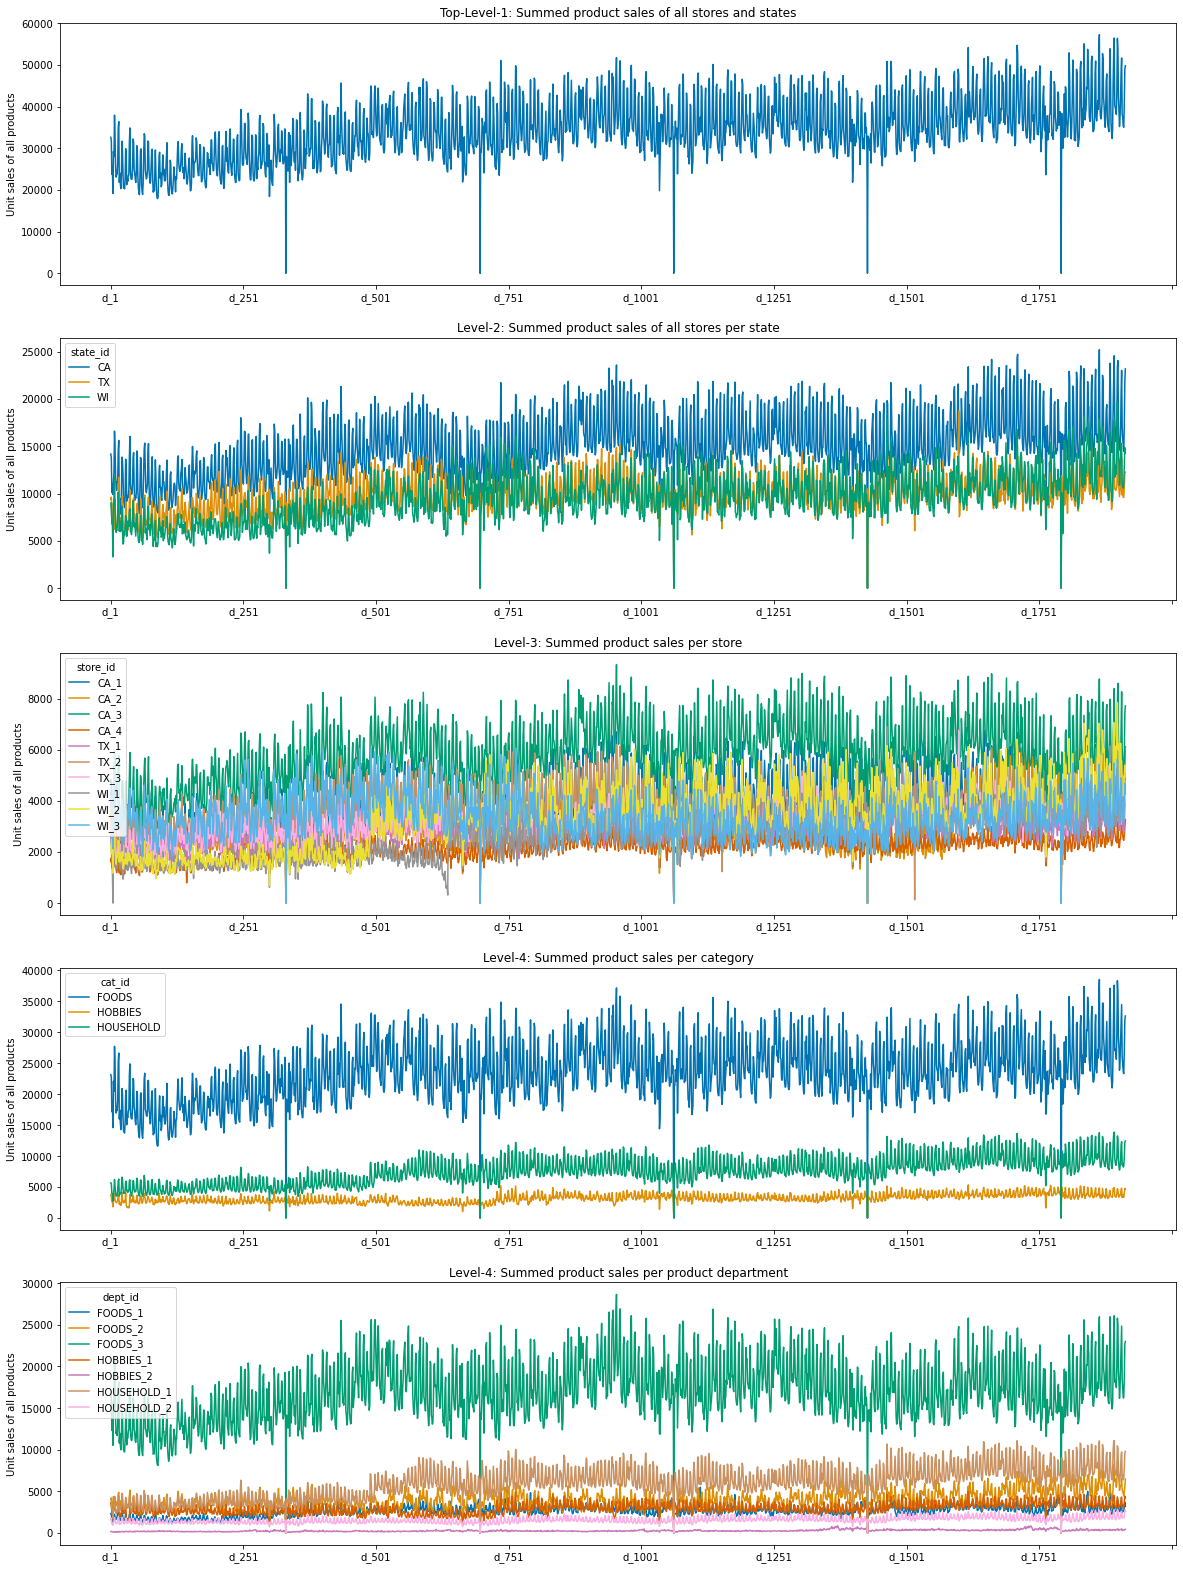

In [7]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
df_train[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
df_train.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
df_train.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
df_train.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
df_train.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");

### Insights

* It has become much clearer how these levels are aggregated by performing groupby- and summing up the sales.
* We can already observe nice periodic patterns. 

# The submission format <a class="anchor" id="submission"></a>

## Intro <a class="anchor" id="intro"></a>

* We have 28 F-columns as we are predicting daily sales for the next 28 days. 
* We are asked to make uncertainty estimates for these days.

In [8]:
submission_sample =pd.read_csv('/kaggle/input/m5-forecasting-uncertainty/sample_submission.csv')
submission_sample.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,Total_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CA_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TX_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,WI_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CA_1_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,CA_2_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,CA_3_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,CA_4_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,TX_1_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,TX_2_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


* In the first submission row we are asked to make precitions for the top level 1 (unit sales of all products, aggregated for all stores/states)
* The next 3 rows represent level 2.
* Followed by level 3 and so on
* Some rows contain aggregations at different levels. An X indicates the absence of an second aggregration level.
* The prediction interval can be validation (related to the public leaderboard) or evaluation (related to the private leaderboard).

An overview of the different levels is given in the Competitors Guide as follows:

| Level id|	Aggregation Level|	Number of series|
|:----|:----|:----|
|1|Unit sales of all products, aggregated for all stores/states|	1|
|2|Unit sales of all products, aggregated for each State|	3|
|3|Unit sales of all products, aggregated for each store| 	10|
|4|Unit sales of all products, aggregated for each category|	3|
|5|Unit sales of all products, aggregated for each department|	7|
|6|Unit sales of all products, aggregated for each State and category|	9|
|7|Unit sales of all products, aggregated for each State and department|	21|
|8|Unit sales of all products, aggregated for each store and category|	30|
|9|Unit sales of all products, aggregated for each store and department|	70|
|10|Unit sales of product x, aggregated for all stores/states|	3,049|
|11|Unit sales of product x, aggregated for each State|	9,147|
|12|Unit sales of product x, aggregated for each store|	30,490|
| |**Total**|**42,840**|

## Prediction intervals and quantiles <a class="anchor" id="PIs"></a>

Given that forecasters will be asked to provide the median, and the 50%, 67%, 95%, and 99% PIs, u is set to u1=0.005, u2=0.025, u3=0.165, u4=0.25, u5=0.5, u6=0.75, u7=0.835, u8=0.975, and u9=0.995, therefore leading to the following quartiles:

* 99% PI - $u_{1} = 0.005$ and $u_{9} = 0.995$
* 95% PI - $u_{2} = 0.025$ and $u_{8} = 0.975$
* 67% PI - $u_{3} = 0.165$ and $u_{7} = 0.835$
* 50% PI - $u_{4} = 0.25$ and $u_{6} = 0.75$
* median - $u_{5} = 0.5$

In [9]:
# total number of series * number of quartiles * 2 (validation & evaluation)
42840*9*2

771120

In [10]:
submission_sample.shape

(771120, 29)

## Outlier <a class="anchor" id="outlier"></a>

At certain days, sales dropped significantly (e.g. christmas).

Here, we take a look at peak days (i.e. peaks in terms of zero sales) on an overall levelm:

Text(0.5, 0, 'Days')

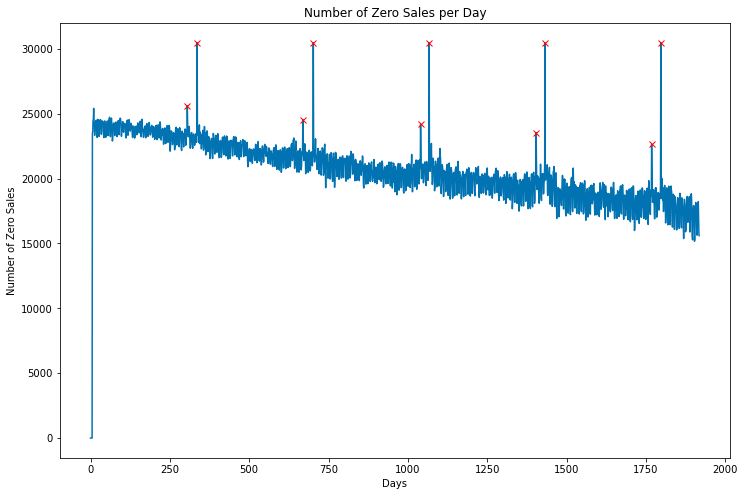

In [11]:
temp_series = df_train
plt.figure(figsize=(12,8))
peak_days = []
x = np.count_nonzero(temp_series==0, axis=0)
peaks, _ = sc.signal.find_peaks(x, height=np.quantile(x,0.75), threshold=max(x)/25)
peak_d = temp_series.columns[peaks]
peak_days=peak_d
plt.plot(x)
plt.plot(peaks, x[peaks], "x", color='red')
    
plt.title('Number of Zero Sales per Day')
plt.ylabel('Number of Zero Sales')
plt.xlabel('Days')

In [12]:
peak_days

Index(['d_300', 'd_331', 'd_664', 'd_697', 'd_1035', 'd_1062', 'd_1399',
       'd_1427', 'd_1763', 'd_1792'],
      dtype='object')

In [13]:
df_days[df_days['d'].isin(peak_days)]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
299,2011-11-24,11143,Thursday,6,11,2011,d_300,Thanksgiving,National,NaN,NaN,0,0,0
330,2011-12-25,11148,Sunday,2,12,2011,d_331,Christmas,National,NaN,NaN,0,0,0
663,2012-11-22,11243,Thursday,6,11,2012,d_664,Thanksgiving,National,NaN,NaN,0,0,0
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,NaN,NaN,0,0,0
1034,2013-11-28,11344,Thursday,6,11,2013,d_1035,Thanksgiving,National,NaN,NaN,0,0,0
1061,2013-12-25,11348,Wednesday,5,12,2013,d_1062,Christmas,National,NaN,NaN,0,0,0
1398,2014-11-27,11443,Thursday,6,11,2014,d_1399,Thanksgiving,National,NaN,NaN,0,0,0
1426,2014-12-25,11447,Thursday,6,12,2014,d_1427,Christmas,National,NaN,NaN,0,0,0
1762,2015-11-26,11543,Thursday,6,11,2015,d_1763,Thanksgiving,National,NaN,NaN,0,0,0
1791,2015-12-25,11547,Friday,7,12,2015,d_1792,Christmas,National,NaN,NaN,0,0,0


At almost every outlier day, there is a special vent like thanksgiving or christmas.

In [14]:
peak_days_before=[]
peak_days_after=[]

for i, days in enumerate(peak_days):
    peak_days_before.append('d_'+str(np.int(peak_days[i][2:])-1))
    peak_days_after.append('d_'+str(np.int(peak_days[i][2:])+1))

In [15]:
df_train_no_outlier = df_train.copy().T[1:]
df_train_no_outlier.columns = df_train.T.iloc[0]

for x,y,z in zip(peak_days,peak_days_before,peak_days_after):
        df_train_no_outlier[df_train_no_outlier.index==x] = np.reshape([pd.concat([df_train_no_outlier[df_train_no_outlier.index==y],df_train_no_outlier[df_train_no_outlier.index==z]],axis=0).mean()],(1,30490))

df_train_no_outlier = df_train_no_outlier.T.reset_index()

In [16]:
df_train_no_outlier = pd.concat([df_train_no_outlier[level_cols],df_train_no_outlier[series_cols].apply(pd.to_numeric,downcast='float')],axis=1)
df_train_no_outlier = reduce_mem_usage(df_train_no_outlier)

Mem. usage decreased to 112.65 Mb (49.7% reduction)


In [17]:
df_train_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: float16(1913), object(6)
memory usage: 112.6+ MB


Let's take a look if this worked

(0.0, 30000.0)

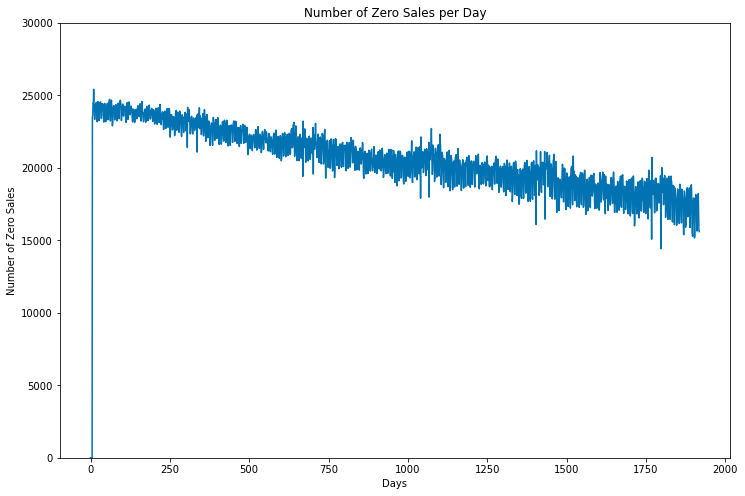

In [18]:
temp_series = df_train_no_outlier
plt.figure(figsize=(12,8))
x = np.count_nonzero(temp_series==0, axis=0)
plt.plot(x)
    
plt.title('Number of Zero Sales per Day')
plt.ylabel('Number of Zero Sales')
plt.xlabel('Days')
plt.ylim(0,30000)

In [19]:
del temp_series, peak_days_before, peak_days_after, peak_d, peak_days, peaks

In [20]:
del df_train

## Aggregation levels <a class="anchor" id="sub_aggregation_levels"></a>

In [21]:
df_train_no_outlier.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

As seen in the table above, we are going to create the 12 Levels one after another through grouping statements 

In [22]:
series_cols = df_train_no_outlier.columns[df_train_no_outlier.columns.str.contains("d_")].values
level_cols = df_train_no_outlier.columns[df_train_no_outlier.columns.str.contains("d_")==False].values

In [23]:
Level1 = pd.DataFrame(df_train_no_outlier[series_cols].sum(),columns={'Total'}).T
Level2 = df_train_no_outlier.groupby("state_id")[series_cols].sum()
Level3 = df_train_no_outlier.groupby("store_id")[series_cols].sum()
Level4 = df_train_no_outlier.groupby("cat_id")[series_cols].sum()
Level5 = df_train_no_outlier.groupby("dept_id")[series_cols].sum()

Level6 = df_train_no_outlier.groupby(["state_id",'cat_id'])[series_cols].sum().reset_index()
Level6['index']=''
for row in range(len(Level6)):
    Level6['index'][row]=str(Level6['state_id'][row])+'_'+str(Level6['cat_id'][row])
Level6.set_index(Level6['index'],inplace=True)
Level6.drop(['state_id','cat_id','index'],axis=1,inplace=True)

Level7 = df_train_no_outlier.groupby(["state_id",'dept_id'])[series_cols].sum().reset_index()
Level7['index']=''
for row in range(len(Level7)):
    Level7['index'][row]=str(Level7['state_id'][row])+'_'+str(Level7['dept_id'][row])
Level7.set_index(Level7['index'],inplace=True)
Level7.drop(['state_id','dept_id','index'],axis=1,inplace=True)

Level8 = df_train_no_outlier.groupby(["store_id",'cat_id'])[series_cols].sum().reset_index()
Level8['index']=''
for row in range(len(Level8)):
    Level8['index'][row]=str(Level8['store_id'][row])+'_'+str(Level8['cat_id'][row])
Level8.set_index(Level8['index'],inplace=True)
Level8.drop(['store_id','cat_id','index'],axis=1,inplace=True)

Level9 = df_train_no_outlier.groupby(["store_id",'dept_id'])[series_cols].sum().reset_index()
Level9['index']=''
for row in range(len(Level9)):
    Level9['index'][row]=str(Level9['store_id'][row])+'_'+str(Level9['dept_id'][row])
Level9.set_index(Level9['index'],inplace=True)
Level9.drop(['store_id','dept_id','index'],axis=1,inplace=True)

Level10= df_train_no_outlier.groupby(["item_id"])[series_cols].sum()


Level11= df_train_no_outlier.groupby(["item_id",'state_id'])[series_cols].sum().reset_index()
Level11['index']=''
for row in range(len(Level11)):
    Level11['index'][row]=str(Level11['item_id'][row])+'_'+str(Level11['state_id'][row])
Level11.set_index(Level11['index'],inplace=True)
Level11.drop(['item_id','state_id','index'],axis=1,inplace=True)


Level12= df_train_no_outlier.copy()
Level12.set_index(Level12['id'],inplace=True, drop =True)
Level12.drop(level_cols,axis=1,inplace=True)

df=pd.concat([Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Level9,Level10,Level11,Level12])

del Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Level9,Level10,Level11,Level12

Now, we need to test, whether the combination of the levels is right and the rows contain the same input. We are going to do this by comparing the row names.

In [24]:
test = pd.concat([df.reset_index()['index'],submission_sample.reset_index().id[:42840]],axis=1)
test
test['index'].replace('_validation','',regex=True,inplace=True)

In [25]:
test['proof'] = ''
for row in range(len(test)):
    if test['index'][row] in test['id'][row]:
        test['proof'][row]=True
test[test['proof']==False]

,index,id,proof


Every combination is fine and in the right order.

In [26]:
del test

# Feature Creation  <a class="anchor" id="Feature_Creation"></a>

In the next part we have to decide how many features we want to take for test and training datasets. 

## Limited Features <a class="anchor" id="limfeat"></a>

In the first part we are taking only one extra feature (i.e. limited features).

In [27]:
df_days["date"] = pd.to_datetime(df_days['date'])
df_days.set_index('date', inplace=True)

df_days['is_event_day'] = [1 if x ==False else 0 for x in df_days['event_name_1'].isnull()] 
df_days['is_event_day'] = df_days['is_event_day'].astype(np.int8)

day_before_event = df_days[df_days['is_event_day']==1].index.shift(-1,freq='D')
df_days['is_event_day_before'] = 0
df_days['is_event_day_before'][df_days.index.isin(day_before_event)] = 1
df_days['is_event_day_before'] = df_days['is_event_day_before'].astype(np.int8)

del day_before_event

daysBeforeEventTest = df_days['is_event_day_before'][1913:1941]
daysBeforeEvent = df_days['is_event_day_before'][startDay:1913]
daysBeforeEvent.index = df_train_no_outlier.index[startDay:1913]

In [28]:
df_final = pd.concat([df.T.reset_index(drop=True), daysBeforeEvent.reset_index(drop=True)], axis = 1)
df_final = df_final[startDay:]

## More Features <a class="anchor" id="morefeat"></a>
Next, we want to increase our number of features a little.

In [29]:
df_days

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_event_day,is_event_day_before
date,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0,0
2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0,0
2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0,0
2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,0
2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,0,0
2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,0,0
2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,0,0


In [30]:
features = df_days[['is_event_day_before','wday','snap_CA','snap_TX','snap_WI']]
features.head()

,is_event_day_before,wday,snap_CA,snap_TX,snap_WI
date,,,,,
2011-01-29,0,1,0,0,0
2011-01-30,0,2,0,0,0
2011-01-31,0,3,0,0,0
2011-02-01,0,4,1,1,0
2011-02-02,0,5,1,0,1


### Pricing Feature <a class="anchor" id="pricefeat"></a>

What if we add prices for the products? Though we only have them on a weekly level, they could increase the model.

Even, if we take prices per product per week, we have to take into account 3049 products * 282 weeks leading to 859818 additional columns.

However, if we group by store and category, we receive 10 (stores) * 3 (categories),therefore, only 30 additional columns.

In [31]:
# adding 'id' column as well as 'cat_id', 'dept_id' and 'state_id', then changing the type to 'categorical'
df_prices.loc[:, "id"] = df_prices.loc[:, "item_id"] + "_" + df_prices.loc[:, "store_id"] + "_validation"
df_prices['state_id'] = df_prices['store_id'].str.split('_',expand=True)[0]
df_prices = pd.concat([df_prices, df_prices["item_id"].str.split("_", expand=True)], axis=1)
df_prices = df_prices.rename(columns={0:"cat_id", 1:"dept_id"})
df_prices[["store_id", "item_id", "cat_id", "dept_id", 'state_id']] = df_prices[["store_id","item_id", "cat_id", "dept_id", 'state_id']].astype("category")
df_prices = df_prices.drop(columns=2)

In [32]:
price_features = pd.DataFrame(df_prices.groupby(['wm_yr_wk','store_id','cat_id'])['sell_price'].mean().reset_index())
price_features['sell_price'] = price_features['sell_price'].astype('float32')

In [33]:
price_features['store_cat'] = 0

for row in range(len(price_features)):
     price_features['store_cat'][row]=str(price_features['store_id'][row])+'_'+str(price_features['cat_id'][row])

In [34]:
price_features= price_features.pivot(index='store_cat',columns='wm_yr_wk',values='sell_price').T
price_features.head()

store_cat,CA_1_FOODS,CA_1_HOBBIES,CA_1_HOUSEHOLD,CA_2_FOODS,CA_2_HOBBIES,CA_2_HOUSEHOLD,CA_3_FOODS,CA_3_HOBBIES,CA_3_HOUSEHOLD,CA_4_FOODS,CA_4_HOBBIES,CA_4_HOUSEHOLD,TX_1_FOODS,TX_1_HOBBIES,TX_1_HOUSEHOLD,TX_2_FOODS,TX_2_HOBBIES,TX_2_HOUSEHOLD,TX_3_FOODS,TX_3_HOBBIES,TX_3_HOUSEHOLD,WI_1_FOODS,WI_1_HOBBIES,WI_1_HOUSEHOLD,WI_2_FOODS,WI_2_HOBBIES,WI_2_HOUSEHOLD,WI_3_FOODS,WI_3_HOBBIES,WI_3_HOUSEHOLD
wm_yr_wk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11101,3.148438,4.468750,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719
11102,3.154297,4.406250,5.507812,2.878906,4.597656,5.632812,3.058594,4.558594,5.632812,3.050781,5.109375,5.617188,2.982422,4.667969,5.441406,2.988281,4.640625,5.468750,2.984375,4.722656,5.468750,2.802734,4.695312,5.601562,2.861328,4.882812,5.703125,3.023438,4.625000,5.382812
11103,3.128906,4.460938,5.578125,2.869141,4.519531,5.597656,3.070312,4.488281,5.675781,3.058594,5.015625,5.625000,2.984375,4.585938,5.468750,2.988281,4.605469,5.558594,3.003906,4.742188,5.515625,2.832031,4.554688,5.593750,2.859375,4.808594,5.769531,3.058594,4.550781,5.433594
11104,3.123047,4.421875,5.578125,2.861328,4.527344,5.589844,3.078125,4.488281,5.664062,3.064453,5.011719,5.667969,2.984375,4.542969,5.476562,2.990234,4.550781,5.546875,2.998047,4.746094,5.566406,2.822266,4.531250,5.632812,2.880859,4.761719,5.812500,3.056641,4.496094,5.515625
11105,3.126953,4.433594,5.566406,2.853516,4.539062,5.593750,3.082031,4.468750,5.687500,3.070312,5.003906,5.664062,2.974609,4.550781,5.539062,2.984375,4.476562,5.570312,2.990234,4.750000,5.585938,2.820312,4.515625,5.671875,2.888672,4.753906,5.839844,3.041016,4.492188,5.507812


In [35]:
features = df_days[['wm_yr_wk','is_event_day_before','wday','snap_CA','snap_TX','snap_WI']]
features.head()
features = pd.merge(features.reset_index(),price_features,how='left', left_on='wm_yr_wk', right_on='wm_yr_wk').set_index('date')
features.drop('wm_yr_wk', axis=1, inplace=True)
features.head()

,is_event_day_before,wday,snap_CA,snap_TX,snap_WI,CA_1_FOODS,CA_1_HOBBIES,CA_1_HOUSEHOLD,CA_2_FOODS,CA_2_HOBBIES,CA_2_HOUSEHOLD,CA_3_FOODS,CA_3_HOBBIES,CA_3_HOUSEHOLD,CA_4_FOODS,CA_4_HOBBIES,CA_4_HOUSEHOLD,TX_1_FOODS,TX_1_HOBBIES,TX_1_HOUSEHOLD,TX_2_FOODS,TX_2_HOBBIES,TX_2_HOUSEHOLD,TX_3_FOODS,TX_3_HOBBIES,TX_3_HOUSEHOLD,WI_1_FOODS,WI_1_HOBBIES,WI_1_HOUSEHOLD,WI_2_FOODS,WI_2_HOBBIES,WI_2_HOUSEHOLD,WI_3_FOODS,WI_3_HOBBIES,WI_3_HOUSEHOLD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,1,0,0,0,3.148438,4.46875,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719
2011-01-30,0,2,0,0,0,3.148438,4.46875,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719
2011-01-31,0,3,0,0,0,3.148438,4.46875,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719
2011-02-01,0,4,1,1,0,3.148438,4.46875,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719
2011-02-02,0,5,1,0,1,3.148438,4.46875,5.414062,2.876953,4.605469,5.558594,3.042969,4.585938,5.613281,2.953125,5.054688,5.457031,2.949219,4.675781,5.320312,2.957031,4.691406,5.460938,2.929688,4.742188,5.292969,2.759766,4.632812,5.472656,2.806641,4.871094,5.464844,2.988281,4.523438,5.261719


In [36]:
features_test = features.iloc[1913:1941,:]
features_train = features.iloc[startDay:1913,:]
df_final_more = pd.concat([df.T.reset_index(drop=True), features_train.reset_index(drop=True)], axis = 1)
df_final = df_final_more.copy()

In [37]:
del df_final_more, features

## Feature Scaling <a class="anchor" id="featscale"></a>
For better modeling, we are scaling features using min-max scaler in range 0-1.

In [38]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dt_scaled = sc.fit_transform(df_final)

In [39]:
gc.collect()

134

## Generating Train and Test Data <a class="anchor" id="traintest"></a>

In the next step, let's create X_train and y_train by creating different dataframes with 14 days of projection. For y_train we only use sales values for predictions. As we only predict sales, only 0:42840 columns are choosen.

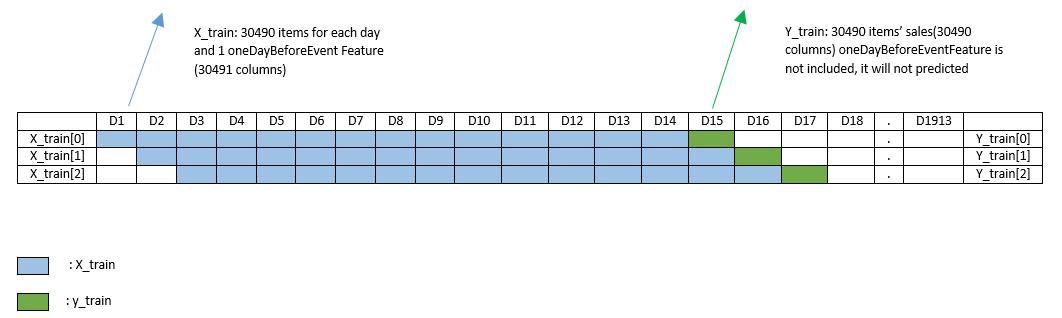

In [40]:
X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay):
    X_train.append(dt_scaled[i-timesteps:i])
    y_train.append(dt_scaled[i][0:42840]) 
    
X_train = np.array(X_train)
y_train = np.array(y_train)
print('Shape of X_train :'+str(X_train.shape))
print('Shape of y_train :'+str(y_train.shape))

Shape of X_train :(1899, 14, 42875)
Shape of y_train :(1899, 42840)


In [41]:
inputs = df_final[-timesteps:]
inputs = sc.transform(inputs)

In [42]:
%who

MinMaxScaler	 SEED	 X_train	 ax	 days	 daysBeforeEvent	 daysBeforeEventTest	 df	 df_days	 
df_final	 df_prices	 df_train_no_outlier	 dt_scaled	 features_test	 features_train	 fig	 gc	 i	 
inputs	 level_cols	 np	 pd	 plt	 price_features	 reduce_mem_usage	 roc_auc_score	 row	 
sc	 series_cols	 signal	 skl	 sns	 startDay	 submission_sample	 time	 timesteps	 
warnings	 x	 y	 y_train	 z	 


In [43]:
del df_train_no_outlier, df_prices, df_days, df, df_final, dt_scaled, price_features

In [44]:
gc.collect()

40

# LSTM Modeling <a class="anchor" id="Modeling"></a>

Next, we start our modelling. We will use LSTM Neural Networks with different layers. 

In general, neural networks are easily described by the following picture:
1. The neural network model starts with random weights and tries to find the best weights for the different layers, predicting outcomes and comparing them with the true target outcomes. For this it uses the loss function. 
2. The loss function measures the quality of  the network’s output
3. Then, the loss score is used as a feedback signal to adjust the weights.

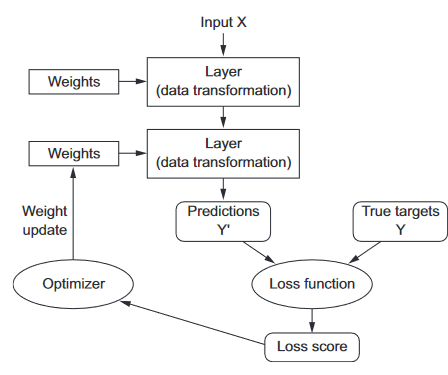

## Loss Function <a class="anchor" id="lossfct"></a>

In the M5 we have to project different aggregation levels at certain quantiles. All that changes in comparison to the [baseline lstm](https://www.kaggle.com/bountyhunters/baseline-lstm-with-keras-0-7#Future-Improvements) is the loss function. The following few lines defines the loss function defined in the section above.

In [45]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)

## Running the Model <a class="anchor" id="runmodel"></a>

When creating X_test, we are using the last 14 days in order to predict day 1915 sales. Therefore, in order to predict 1916th day, 13 days from our input data and 1 day from our prediction are used. After that we slide the window one by one, i.e.:

* 12 days from input data + 2 days from our prediction to predict 1917th day
* 11 days from input data + 3 days from our prediction to predict 1918th day
* .....
* 14 days our prediction to predict last 1941th day sales.



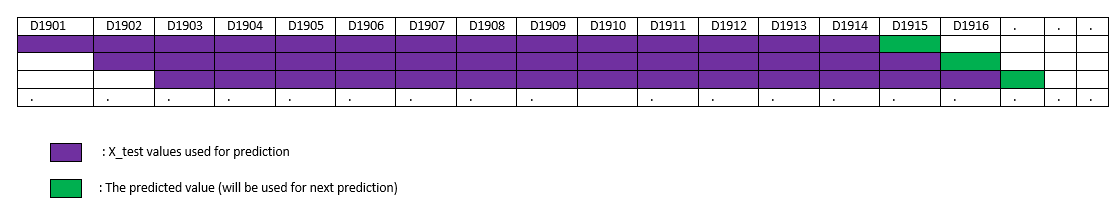

In [46]:
QUANTILES = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [47]:
EPOCHS = 32 # going through the dataset 32 times
BATCH_SIZE = 32 # with each training step the model sees 32 examples

In [48]:
# Importing the Keras libraries and packages
import tensorflow_probability as tfp
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
import keras

def run_model(X_train, y_train, q):

    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=40
    model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=300
    model.add(LSTM(units = layer_2_units, return_sequences = True))
    model.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    layer_3_units=300
    model.add(LSTM(units = layer_3_units))
    model.add(Dropout(0.2))

    # Adding the output layer
    model.add(Dense(units = y_train.shape[1]))

    # Compiling the RNN
    model.compile(optimizer = 'adam',loss=lambda y, f: tilted_loss(q, y, f))
    
    # To follow at which quantile we are predicting right now  
    print('Running the model for Quantil: '+str(q)+':')

    # Fitting the RNN to the Training set
    fit = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=2)
    
    X_test = []
    X_test.append(inputs[0:timesteps])
    X_test = np.array(X_test)
    prediction = []
     
    for j in range(timesteps,timesteps + 28):
        predicted_volume = model.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, 42875)) #incl. features
        testInput = np.column_stack((np.array(predicted_volume), np.array(features_test.iloc[j-timesteps,:]).reshape(1,35))) #here no of features is 5
        X_test = np.append(X_test, testInput).reshape(1,j + 1,42875) #incl. features
        predicted_volume = sc.inverse_transform(testInput)[:,0:42840] #without features
        prediction.append(predicted_volume)
    
    prediction = pd.DataFrame(data=np.array(prediction).reshape(28,42840)).T
    return prediction

Using TensorFlow backend.


In [49]:
# We run the model for all the quantiles mentioned above. 
# Combining all quantile predictions one after another to a large dataset.
predictions = pd.concat(
    [run_model(X_train, y_train, q) 
     for q in QUANTILES]) 

Running the model for Quantil: 0.005:
Epoch 1/32
 - 44s - loss: 4.8903e-04
Epoch 2/32
 - 41s - loss: 4.4879e-04
Epoch 3/32
 - 41s - loss: 4.4256e-04
Epoch 4/32
 - 40s - loss: 4.4418e-04
Epoch 5/32
 - 38s - loss: 4.5008e-04
Epoch 6/32
 - 39s - loss: 4.5248e-04
Epoch 7/32
 - 39s - loss: 4.5323e-04
Epoch 8/32
 - 40s - loss: 4.5346e-04
Epoch 9/32
 - 39s - loss: 4.5352e-04
Epoch 10/32
 - 39s - loss: 4.5343e-04
Epoch 11/32
 - 40s - loss: 4.5337e-04
Epoch 12/32
 - 41s - loss: 4.5337e-04
Epoch 13/32
 - 41s - loss: 4.5340e-04
Epoch 14/32
 - 40s - loss: 4.5352e-04
Epoch 15/32
 - 40s - loss: 4.5327e-04
Epoch 16/32
 - 40s - loss: 4.5332e-04
Epoch 17/32
 - 40s - loss: 4.5325e-04
Epoch 18/32
 - 40s - loss: 4.5335e-04
Epoch 19/32
 - 39s - loss: 4.5351e-04
Epoch 20/32
 - 40s - loss: 4.5343e-04
Epoch 21/32
 - 40s - loss: 4.5336e-04
Epoch 22/32
 - 39s - loss: 4.5342e-04
Epoch 23/32
 - 40s - loss: 4.5328e-04
Epoch 24/32
 - 40s - loss: 4.5325e-04
Epoch 25/32
 - 39s - loss: 4.5335e-04
Epoch 26/32
 - 40s - 

In [50]:
gc.collect()

10859

In [51]:
predictions.shape

(385560, 28)

We can see that our shape matches the requested outcome. Multiplying by two (for the validation and evaluation data).

In [52]:
predictions.shape[0]*2

771120

## Creating the Submission File <a class="anchor" id="submission"></a>

Finally, let's create a submission file, using the ids of the sample submission. As we have the validation and evaluation data, we need to stack the submission file on top of itself.

In [53]:
predictions.to_pickle('Uncertainty_Predictions.pkl')

In [54]:
submission = pd.concat((predictions, predictions), ignore_index=True)
idColumn = submission_sample[["id"]]    
submission[["id"]] = idColumn  

#re-arranging collumns
cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]
#
colsname = ["id"] + [f"F{i}" for i in range (1,29)]
submission.columns = colsname

submission.to_csv("submission.csv", index=False)

Let's take a look at one of the predicted datasets (here we take the median with quantile = 0.5)

We want to test, whether the sum of our daily predictions on the different levels equal to level1 (Total levels).

In [55]:
temp_series = submission[171360:171360+42840]

border = [1,3,10,3,7,9,21,30,70,3049,9147,30490]
sumi = 0
levels =[]
for i in border:
    sumi += i
    levels.append(pd.DataFrame(temp_series[sumi-i:sumi]))


for i,level in enumerate(levels):
    levels[i] = levels[i].sum()

Let's take a look at it graphically:

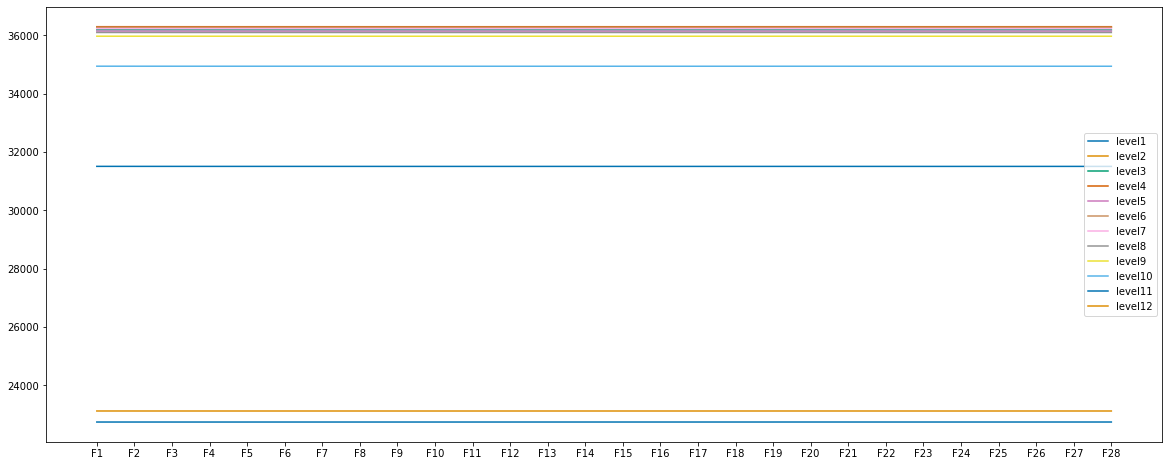

In [56]:
plt.figure(figsize=(20, 8))

for i in range(12):
    plt.plot(levels[i][1:],label='level'+str(i+1))

plt.legend()

Level 12, 11 and 10 (the most detailled ones) have the lowest total sums. Level12 is approx 2/3 the sum of level 1

Let's plot them at different levels to see if the curves move similarly.

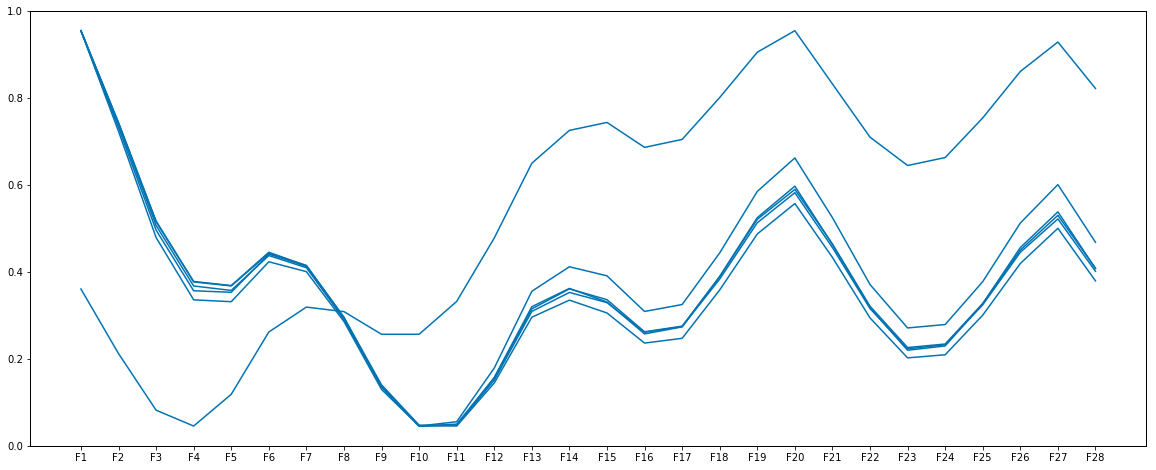

In [57]:
fig,ax = plt.subplots(figsize=(20, 8))

for i in range(6):
    ax = ax.twinx()
    ax.plot(levels[i][1:],label='level'+str(i+1))
    plt.yticks([])

At least, they all have similar ups and downs!

Please feel free to share any ideas for improvement as a comment and we can discuss more in detail